# Texture-based separation to refine building meshes 

- Use Texture segmentation to separate the different materials in the meshes
- Detect the edges on the texture
- Convert the detected edges to hough lines
- project the uv coordinates of the mesh onto the plane
- Cut the triangles with the detected lines
- Define the new faces with the edge boundaries


In [1]:
%load_ext autoreload
%autoreload 2

from context import segmentationtools
import cv2
import open3d as o3d
import math
import numpy as np
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#import the 3D mesh
meshPath = "../../../localfiles/DemoHouse.obj"
mesh = o3d.io.read_triangle_mesh(meshPath, True)

## Texture Segmentation

- We want to group textures and reduce their detail for better edge detection
- use Factorisation based Texture segmentation


In [3]:
import segmentationtools.fseg as fseg

texture = np.asarray(mesh.textures[0])
grayTexture = cv2.resize(cv2.cvtColor(texture, cv2.COLOR_BGR2GRAY), (512, 512))

# define filter bank and apply to image. for color images, convert rgb to grey scale and then apply filter bank
filter_list = [('log', .5, [3, 3]), ('log', 1, [5, 5]),
                ('gabor', 1.5, 0), ('gabor', 1.5, math.pi/2), ('gabor', 1.5, math.pi/4), ('gabor', 1.5, -math.pi/4),
                ('gabor', 2.5, 0), ('gabor', 2.5, math.pi/2), ('gabor', 2.5, math.pi/4), ('gabor', 2.5, -math.pi/4)
                ]
filter_out = fseg.image_filtering(grayTexture, filter_list=filter_list)
# include original image as one band
Ig = np.concatenate((np.float32(grayTexture.reshape((grayTexture.shape[0], grayTexture.shape[1], 1))), filter_out), axis=2)
# run segmentation. try different window size, with and without nonneg constraints
segmentedTexture = fseg.Fseg(Ig, ws=10, segn=0, omega=.2, nonneg_constraint=False)

[7.84832750e-08 1.31643816e-07 1.61891563e-07 1.71823899e-07
 1.75691810e-07 1.82947957e-07 1.94105809e-07 2.08984034e-07
 2.36330592e-07 2.68824692e-07 3.17425730e-07 3.73142001e-07
 4.34755606e-07 5.06561548e-07 5.93373784e-07 6.92007120e-07
 8.07263234e-07 9.36592187e-07 1.10635142e-06 1.29244313e-06
 1.49891866e-06 1.72579269e-06 1.99103579e-06 2.32299089e-06
 2.69472594e-06 3.17151830e-06 3.74297178e-06 4.40032818e-06
 5.22555365e-06 6.23323604e-06 7.43478131e-06 8.81503001e-06
 1.05619392e-05 1.26986424e-05 1.49594580e-05 1.74835641e-05
 2.00754803e-05 2.30910991e-05 2.64941427e-05 2.99542990e-05
 3.42471176e-05 3.87907457e-05 4.44634825e-05 5.13970881e-05
 5.84294357e-05 6.78903962e-05 7.77393507e-05 8.86825801e-05
 1.01746518e-04 1.16899726e-04 1.33915673e-04 1.51443281e-04
 1.70033891e-04 1.89343613e-04 2.10269369e-04 2.31826198e-04
 2.55472551e-04 2.82878958e-04 3.10795702e-04 3.43185617e-04
 3.78630240e-04 4.17331757e-04 4.63773322e-04 5.16326225e-04
 5.72376477e-04 6.353229

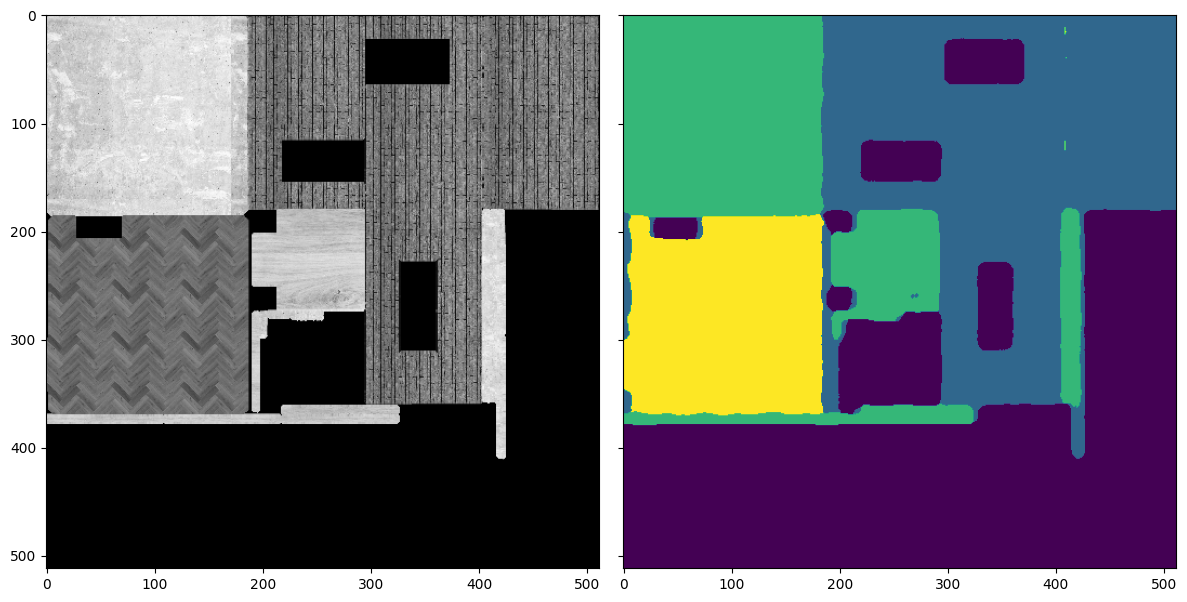

In [4]:
# show results
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 6))
ax[0].imshow(grayTexture, cmap='gray')
ax[1].imshow(segmentedTexture)
plt.tight_layout()
plt.show()

In [4]:

a = segmentedTexture
segmentedMappedTexture = np.round(np.interp(a, (a.min(), a.max()), (0, 255))).astype(np.uint8)


## Edge Detection

- The patched image is pefect to detect the boundaries of the textures
- Use canny or HED edge detection
- Find the hough lines to get straight lines in the dtected edges

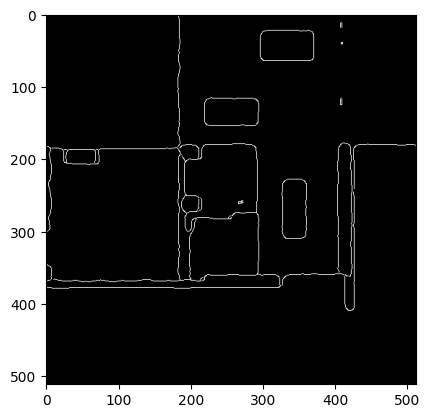

In [5]:
# perform Canny edge tedection to find sharp gradients
dst = cv2.Canny(segmentedMappedTexture, 100, 300, None, 3)
dstp = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

segmentationtools.show_img(dstp)

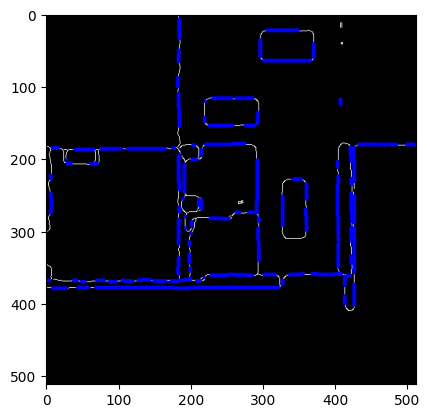

In [6]:
dstp2 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
linesP = cv2.HoughLinesP(dst, 1, np.pi / 360, 30, None, 0, 0)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(dstp2, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

segmentationtools.show_img(dstp2)

[[[ 183.           0.       ]]

 [[ 377.           1.5707964]]

 [[ 425.           0.       ]]

 [[ 403.           0.       ]]

 [[-417.           3.1154127]]

 [[ 291.           0.       ]]

 [[ 179.           1.5707964]]]


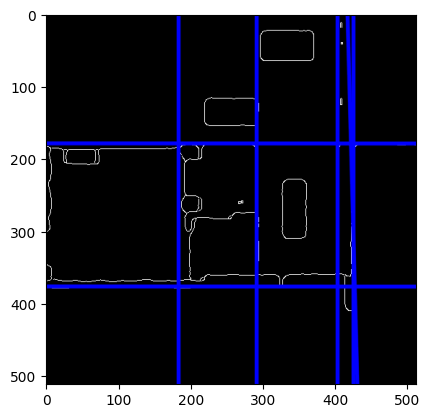

In [33]:
# Lets apply Standard HoughLine transform to detect lines
dstp2 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
lines = cv2.HoughLines(dst, 2, np.pi / 120, 150, None, 0, 0)
print(lines)
# Below we will display the result by drawing lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(dstp2, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

segmentationtools.show_img(dstp2)

## Face Slicing

- slice the triangles that are in the path of the new lines
- check for continuity in adjacent faces to continue the line

UV coordinates: 
 3348
nr of vertices: 
 1260


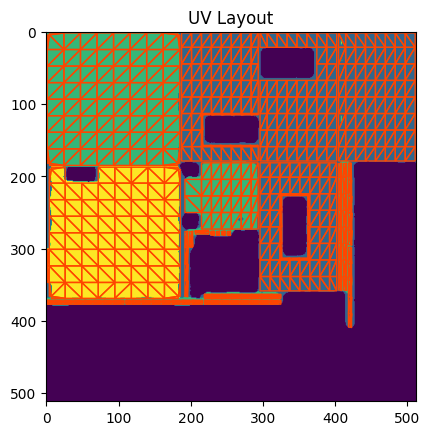

In [8]:
# Plot the triangles on the uv plane
# Scale the uv coordinates with the image dimensions
uvPoints = np.asarray(mesh.triangle_uvs) * np.array([segmentedMappedTexture.shape[1],segmentedMappedTexture.shape[0]])
print("UV coordinates: \n", len(uvPoints))
print("nr of vertices: \n", len(mesh.vertices))
plt.imshow(segmentedMappedTexture)

for i in range((int)(len(uvPoints)/3)):
    plt.fill(*zip(*uvPoints[3*i:3*i+3]), facecolor='none', edgecolor='orangered', linewidth=1)
plt.title('UV Layout')
plt.show()

In [46]:
# Slice all the triangles with the hough lines

import segmentationtools as st
from segmentationtools import find_triangle_intersection, get_edge_points
print(lines[1])
print(get_edge_points(lines[1], segmentedMappedTexture.shape[1], segmentedMappedTexture.shape[0]))


[[377.          1.5707964]]
[[  0.         377.        ]
 [512.         377.00002238]]


The resulting intersection points are: 
 [[183.         181.85170933]
 [183.         174.06098245]
 [183.           4.14571084]
 [183.          11.93683882]
 [183.         211.88935953]
 [183.         232.22323608]
 [183.         252.55709911]
 [183.         232.22323608]
 [183.         275.47590898]
 [183.         255.15519714]
 [183.         298.42103476]
 [183.         278.07400701]
 [183.         321.35301108]
 [183.         301.01913452]
 [183.         344.28498739]
 [183.         323.95111084]
 [183.          25.884156  ]
 [183.          24.20275116]
 [183.          48.81659838]
 [183.          47.13523102]
 [183.          71.74856707]
 [183.          70.06719971]
 [183.          94.68053576]
 [183.          92.9991684 ]
 [183.         117.61250389]
 [183.         115.93113708]
 [183.         140.54446607]
 [183.         138.86309814]
 [183.         190.07527931]
 [183.         191.93973103]
 [183.         373.09434247]
 [183.         371.44257492]
 [183.         375.35299019]
 [

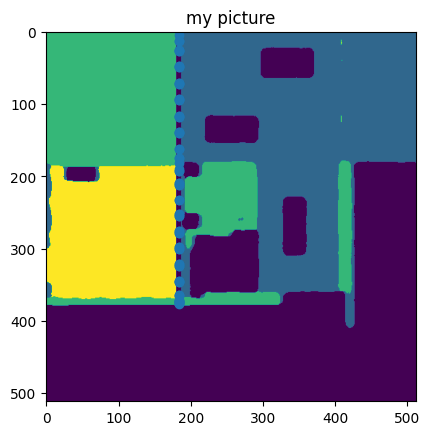

In [69]:

points = []

lineNr = 0

for i in range((int)(len(uvPoints)/3)):
    newPoints = find_triangle_intersection(uvPoints[3*i:3*i+3], get_edge_points(lines[lineNr], segmentedMappedTexture.shape[1], segmentedMappedTexture.shape[0]))
    if (newPoints is not None): 
        points.append(newPoints)

points = np.array(points).reshape((-1,2)) #reshape to a nx2 array
print("The resulting intersection points are: \n", points)

rho = lines[lineNr][0][0]
theta = lines[lineNr][0][1]
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
cv2.line(segmentedMappedTexture, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

plt.imshow(segmentedMappedTexture)
plt.scatter(*zip(*points))
plt.title('my picture')
plt.show()


## Object Segmentation

- use the texture blobs and adjacent faces region growing to segment the different objects

In [95]:
import segmentationtools as st
mesh.textures = [o3d.geometry.Image(cv2.cvtColor(segmentedMappedTexture, cv2.COLOR_GRAY2RGB))]
print(mesh.textures)


[Image of size 512x512, with 3 channels.
Use numpy.asarray to access buffer data.]


In [96]:
st.show_geometries([mesh])

In [ ]:
# split the mesh based on the texture color and adjacency